In [22]:
import pandas as pd
import numpy as np
import dill
import torch.nn as nn
import torch
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os
import random
import copy
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix
from collections import defaultdict, Counter
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.optimizer import required
from torch import optim
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.utils import class_weight
sns.set_theme(style="whitegrid")

In [2]:
bkdatafolder = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"

In [3]:
def createDictFloor(floor_idx,path):
    floorname = f'Floor{floor_idx}'
    fulldata = os.listdir(path)
    getdict = {}
    floors = [floor for floor in fulldata if floorname in floor]
    for name in floors:
        floor_zone = name.split(".")[0]
        getdict[floor_zone] = pd.read_csv(path+name, index_col=0, parse_dates=["Date"])
        getdict[floor_zone] = getdict[floor_zone].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def createDTFeat(date1, date2, datadict, featureX, featureY, resample_method_X="mean", resample_method_Y = "sum" ,scale=True):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for floorname in datadict.keys():
        dataX = datadict[floorname][date1:date2][featureX].copy()
        dataY = datadict[floorname][date1:date2][featureY].copy()
        
        if resample_method_X == "sum":
            dataX = dataX.resample("5T").sum()
            
        elif resample_method_X == "mean":
            dataX = dataX.resample("5T").mean().bfill()
        else:
            pass
        
        if resample_method_Y =="sum":
            dataY = dataY.resample("5T").sum()
        elif resample_method_Y == "mean":
            dataY = dataY.resample("5T").mean().bfill()
        else:
            pass
        
        resample_move[floorname] = pd.concat([dataX, dataY],axis=1)
        resample_move[floorname]["date"] = resample_move[floorname].index.date
        resample_move[floorname]["date"] = resample_move[floorname]["date"].apply(lambda x: x.strftime("%Y-%m-%d"))
    for date in resample_move[floors[0]]["date"]:
        dates.append(str(date))
    dates = sorted(set(dates))
            
    return resample_move, dates
            
        #mysample[data] = resample_move[data].copy()
           
def data_scaling(datadict, feature):
    scalers = {}
    scaled_data_dict = datadict.copy()
    for floorname in datadict.keys():
        cols = datadict[floorname][feature].columns
        idx = datadict[floorname][feature].index
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler.fit(datadict[floorname][feature])
        scaled_data_dict[floorname][feature] = pd.DataFrame(scaler.transform(
                                                datadict[floorname][feature]),columns=cols,index=idx)
        scalers[data] = scaler

    return scaled_data_dict

def getInfoTimeShape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [4]:
def create_power_class(data_dict, conditions, feature):
    keys = sorted(list(data_dict.keys()))
    classes = list(conditions[keys[0]].keys())
    new_datadict = data_dict.copy()
    for floor_name in keys:
        data_dict[floor_name]["ACPowerClass"] = pd.Series(dtype='object')
        for p_class in classes:
            idx_classes = data_dict[floor_name].loc[(data_dict[floor_name][feature] >= conditions[floor_name][p_class][0]) &
                                         (data_dict[floor_name][feature] <= conditions[floor_name][p_class][1])]
            new_datadict[floor_name]["ACPowerClass"].loc[idx_classes.index] = new_datadict[floor_name]["ACPowerClass"].loc[idx_classes.index].apply(lambda x: p_class)
    return new_datadict

In [5]:
date1 = "2019-03-07"
date2 = "2019-12-31"
floor = 7
floor_dict = createDictFloor(floor, bkdatafolder)
for data in floor_dict.keys():
    zone = floor_dict[data]
    print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
    print("")

Floor7Z4 Start: 2019-03-06 14:46:00 End: 2019-12-31 23:59:00 Count:416243

Floor7Z5 Start: 2019-03-06 14:55:00 End: 2019-12-31 23:59:00 Count:407698

Floor7Z2 Start: 2019-03-06 14:48:00 End: 2019-12-31 23:59:00 Count:424701

Floor7Z1 Start: 2019-03-06 14:50:00 End: 2019-12-31 23:59:00 Count:424099



In [6]:
set_point = {"Floor7Z1":{"Low Power":[0,30],
                        "High Power":[30,100]},
            "Floor7Z2":{"Low Power":[0,25],
                       "High Power":[25,100]},
            "Floor7Z4":{"Low Power":[0,25],
                       "High Power":[25,100]},
            "Floor7Z5":{"Low Power":[0,15],
                       "High Power":[15,100]}}

In [15]:
def rolling_window(series, window_size, stride=1):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1, stride)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            databyDate[date][floor] = np.asarray(datadict[floor][date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def LoaderByZoneXY(dataX, dataY, zone_name,dates, seq_len, batch_size, shuffle=False):
    loaderZ = {}
    encode = {"Low Power": 0, "High Power": 1}
    #mid, high, low = 0., 0., 0.
    for i,date in enumerate(dates):
        trainx = rolling_window(dataX[date][zone_name], seq_len)
        trainy = rolling_window(dataY[date][zone_name], seq_len)
        #print(len(trainy))
        to_class_y = torch.zeros((trainy.shape[0])) #[0.]*trainy.shape[0]
        mid, high, low = 0., 0., 0.
        for idx_y in range(trainy.shape[0]):
            selected = select_impact_powerclass(trainy[idx_y])
            if selected == "High Power":
                high += 1
            #elif selected == "Mid Power":
            #    mid += 1
            elif selected == "Low Power":
                low += 1
            to_class_y[idx_y] = encode[selected]
            #print(f'Chosen class {selected} Encode {to_class_y[idx_y]}')
        #print(f'Low count {low} High count {high}')
        xshape = torch.tensor(trainx, dtype=torch.float)
        yshape = torch.tensor(to_class_y, dtype=torch.long)
        #print(xshape.shape, yshape.shape)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=False)
        loaderZ[date] = loaderxy
    return loaderZ

def select_impact_powerclass(y):
    rev_dict = defaultdict(list)
    ct = Counter(y)
    for k,v in ct.items():
        rev_dict[v].append(k)
    list_class = list(rev_dict.keys())
    if len(list_class) == 1:
        key = list_class[0]
        return rev_dict[key][0] 
    else:
        key = max(list_class)
        if len(rev_dict[key]) == 1:
            return rev_dict[key][0]
        elif len(rev_dict[key]) > 1:
            #if "Mid Power" in rev_dict[key]:
            #    return "Mid Power"
            if "High Power" in rev_dict[key]:
                return "High Power"
            else:
                return "Low Power"

In [16]:
featureX = ["temperature"]
featureY = "ACPower"
resample_methodX = "mean"
resample_methodY = "mean"
resample_data, remain_date = createDTFeat(date1, date2, floor_dict, featureX, featureY,resample_method_X=resample_methodX, resample_method_Y=resample_methodY)
resample_data_classes = create_power_class(resample_data, set_point, "ACPower")
scaled_data = data_scaling(resample_data_classes, featureX)

/Users/Slaton/miniforge3/envs/tf_macos/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [17]:
cutting_date = "2019-05-08"
train_date, test_date = splitDate(remain_date, cutting_date)
databyDateX = createDataByDate(scaled_data, featureX, remain_date)
databyDateY = createDataByDate(scaled_data, "ACPowerClass", remain_date)

/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_9547/2444705561.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  databyDate[date][floor] = np.asarray(datadict[floor][date][features])


In [26]:
batch_size = 32
seq_len = 13
nb_zone = 5
trainloader = []
testloader = []
for zone in range(1,nb_zone+1):
    if zone != 3:
        zoneID = f"Floor{floor}Z{zone}"
        print(f'-----{zoneID}-----')
        loaderZtrain = LoaderByZoneXY(databyDateX, databyDateY, zoneID, train_date,seq_len,batch_size, shuffle=True)
        loaderZtest = LoaderByZoneXY(databyDateX, databyDateY, zoneID, test_date,seq_len,batch_size, shuffle=False)
        trainloader.append(loaderZtrain)
        testloader.append(loaderZtest)
zone_no=len(trainloader)

-----Floor7Z1-----


/var/folders/wm/ymsmhgr90dd6gyprvtgvcr080000gn/T/ipykernel_9547/2444705561.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yshape = torch.tensor(to_class_y, dtype=torch.long)


-----Floor7Z2-----
-----Floor7Z4-----
-----Floor7Z5-----


In [27]:
nb_iterations = len(train_date)*len(trainloader[0]["2019-03-08"])
nb_iterations

567

# Algorithm 

In [45]:
import sys
sys.path.append('../src/')

In [46]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from algoaux import *
from optimizerDMFW import *
#from trainer import *
from graphs import *

In [109]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [47]:
def gap_fn(grad, weight, radius):
    fw_gap = 0
    for grad_avg, weight in zip(grad, weight):
        v = lmo(grad_avg, radius)
        fw_gap += torch.sum(torch.mul(grad_avg, weight - v))
    return fw_gap

In [48]:
class OFW(optim.Optimizer):
    def __init__(self, params, eta_coef, eta_exp,radius):
        defaults = dict(eta_coef=eta_coef, eta_exp = eta_exp)
        super(OFW,self).__init__(params, defaults)
        
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]
        self.radius = radius
        self.average_grad = {}
        for group in self.param_groups:
            self.eta_coef = group['eta_coef']
            self.eta_exp = group['eta_exp']
            for k,weight in enumerate(group["params"]):
                self.average_grad[k] = torch.zeros_like(weight)
        self.cpt = 0
            
            
    #@torch.no_grad()
    def grad_sum(self):
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                self.average_grad[k] += weight.grad.data

        self.cpt += 1
        
    def reset(self):
        self.average_grad = {}
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                self.average_grad[k] = torch.zeros_like(weight)
        self.cpt = 0
    
    def step(self,t):
        eta = min(self.eta_coef/(t+1)**(self.eta_exp),1)
        self.gap_val = 0.
        for group in self.param_groups:
            #print(group["params"][0])
            for k,weight in enumerate(group["params"]):
                avg = self.average_grad[k]/self.cpt
                v = lmo(avg,self.radius)
                self.gap_val += torch.sum(torch.mul(avg, weight.data - v))
                weight.data = (1-eta)*weight.data + eta*v 

In [50]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [139]:
class Trainer:
    def __init__(self, loaders, model, model_param, loss,
                 num_iterations):
        #self.graph = graph
        #self.num_nodes = graph.number_of_nodes()
        self.model = model
        self.param = model_param
        #self.A = torch.tensor(nx.adjacency_matrix(graph).toarray())
        self.dataloader = loaders
        self.num_iterations = num_iterations
        self.loss = loss
        self.obj_values = np.ndarray((self.num_iterations + 1, 7),
                                     dtype='float')

        #self.optimizers = [0.] * self.num_nodes
        #self.models = [0.] * self.num_nodes
        #self.losses = [0.] * self.num_nodes
        #self.gaps = [0.]*self.num_nodes

    def reset(self):
        #self.optimizers = [0.] * self.num_nodes
        #self.models = [0.] * self.num_nodes
        #self.losses = [0.] * self.num_nodes
        #self.gaps = [0.] * self.num_nodes

        self.obj_values = np.ndarray((self.num_iterations + 1, 7),
                                     dtype='float')
        
    def __nodeInit(self, data, label):
        nodewrap = TensorDataset(data, label)
        nodes = DataLoader(nodewrap, batch_size=data.size(0), shuffle=False)
        return nodes
            
    def initModelWeight(self, model):
        for name,param in model.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param,0.)
            elif 'weight' in name:
                if not 'batch' in name:
                    nn.init.xavier_normal_(param)
                else:
                    nn.init.uniform_(param)
                    
    def convert_loader_to_batch(self,dataloader, dates, permute=False):
        mydict = {}
        t = 0
        if permute:
            np.random.shuffle(dates)
        for date in dates:
            for couple in dataloader[date]:
                mydict[t] = couple
                t+=1
        return mydict
    
    def train_ofw(self,optimizer, eta_coef, eta_exp,radius, zone_idx,loader,dates):
        seed_everything()
        self.reset()
        
        zone = loader[zone_idx]
        
        self.model_ofw = self.model(*self.param)
        self.optim_ofw = optimizer(self.model_ofw.parameters(), eta_coef, eta_exp, radius)
        
        self.initModelWeight(self.model_ofw)
        
        loader_by_iter = self.convert_loader_to_batch(zone, dates)
        #t = 0
        #for date in dates:
        i = 0
        mydate = dates[i]
        for t in range(self.num_iterations):
            acc, f1, prec, rec, _ , _, _  = ModelPrediction(self.model_ofw,mydate,zone)
            if t%9==0 and (i < len(dates)-1):
                print(t)
                i+=1
                mydate = dates[i] 
            self.model_ofw.train()
            for ts in range(t+1):
                data_prev,label_prev = loader_by_iter[ts]
                self.optim_ofw.zero_grad(set_to_none=True)
                with torch.enable_grad():
                    output_tmp = self.model_ofw(data_prev)
                    loss_tmp = self.loss(output_tmp, label_prev)
                    loss_tmp.backward()
                    
                self.optim_ofw.grad_sum()
                    
            self.optim_ofw.step(t)
            gap = self.optim_ofw.gap_val
            self.optim_ofw.reset()

            print("t : {} Loss : {} Gap {:.4f}, Acc {:.4f} F1 {:.4f} Precision : {:.4f} Recall {:.4f}".format(t, loss_tmp.detach().numpy(),gap,acc,f1,prec,rec))

            self.obj_values[t, :] = [t, loss_tmp.detach().numpy(), gap, acc, f1, prec, rec]

        return self.obj_values

In [140]:
class CNN1D(nn.Module):
    def __init__(self,output_chan, output_dim,input_dim,kernel_size):
        super(CNN1D, self).__init__()
        
        self.output_chan = output_chan
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=output_chan, kernel_size=kernel_size, stride=1, 
                                padding=int(np.floor(kernel_size/2)))
        
        
        self.maxpool = nn.MaxPool1d(3)
        self.batchnorm = nn.BatchNorm1d(output_chan)
        self.fc1 = nn.Linear(output_chan*int((input_dim/3)), output_dim, bias=True)
        
    def forward(self, x):
        inputs = x.unsqueeze(1).squeeze(-1)
        out = self.conv1d(inputs)
        out = self.batchnorm(out)
        out = self.maxpool(out)
        out = nn.LeakyReLU()(out)
        
        out = out.view(-1, out.shape[1]*out.shape[2])
        
        out = self.fc1(out)
        return out

In [141]:
i = 0
for u,v in trainloader[0]["2019-03-07"]:
    i+=1

In [142]:
i

9

In [143]:
num_iter_base = nb_iterations
radius = 1
eta_coef_OFW = 1
eta_exp_OFW = 0.5
loss_fn = nn.CrossEntropyLoss()

In [187]:
zone_no = 3
trainer = Trainer(trainloader, CNN1D, (8,3,seq_len,3), loss_fn,num_iterations=num_iter_base)

In [188]:
obj_val_ofw = trainer.train_ofw(OFW, eta_coef_OFW, eta_exp_OFW, radius,zone_no,trainloader,train_date)

0
t : 0 Loss : 1.4188919067382812 Gap 12.9546, Acc 0.0072 F1 0.0144 Precision : 0.9457 Recall 0.0072
t : 1 Loss : 0.7014713287353516 Gap 0.5808, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 2 Loss : 0.14598433673381805 Gap 0.0717, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 3 Loss : 0.17234782874584198 Gap 0.0527, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 4 Loss : 0.11894246935844421 Gap 1.0114, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 5 Loss : 0.8961440324783325 Gap 1.7725, Acc 0.0000 F1 0.0000 Precision : 0.0000 Recall 0.0000
t : 6 Loss : 0.35966649651527405 Gap 0.5521, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 7 Loss : 0.382622629404068 Gap 1.3001, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 8 Loss : 0.16107586026191711 Gap 0.4894, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
9
t : 9 Loss : 0.15241923928260803 Gap 0.3271, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 10 Los

t : 84 Loss : 0.04008166491985321 Gap 0.0232, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 85 Loss : 0.031869497150182724 Gap 0.0516, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 86 Loss : 0.024086566641926765 Gap 0.0272, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 87 Loss : 0.020655522122979164 Gap 0.0354, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 88 Loss : 0.020280342549085617 Gap 0.0821, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 89 Loss : 0.027663815766572952 Gap 0.0325, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
90
t : 90 Loss : 0.023074589669704437 Gap 0.0392, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 91 Loss : 0.0238177590072155 Gap 0.0438, Acc 0.9783 F1 0.9675 Precision : 0.9570 Recall 0.9783
t : 92 Loss : 0.02044229954481125 Gap 0.0192, Acc 0.9783 F1 0.9675 Precision : 0.9570 Recall 0.9783
t : 93 Loss : 0.017744099721312523 Gap 0.0225, Acc 0.9783 F1 0.9675 Precision : 0.9570 Recal

t : 165 Loss : 0.6224063634872437 Gap 0.0342, Acc 0.9819 F1 0.9729 Precision : 0.9641 Recall 0.9819
t : 166 Loss : 0.5199002623558044 Gap 0.0425, Acc 0.9819 F1 0.9729 Precision : 0.9641 Recall 0.9819
t : 167 Loss : 0.02004420943558216 Gap 0.5902, Acc 0.9819 F1 0.9729 Precision : 0.9641 Recall 0.9819
t : 168 Loss : 0.22591184079647064 Gap 0.2602, Acc 0.9819 F1 0.9729 Precision : 0.9641 Recall 0.9819
t : 169 Loss : 0.35329368710517883 Gap 0.4979, Acc 0.9819 F1 0.9729 Precision : 0.9641 Recall 0.9819
t : 170 Loss : 0.43488606810569763 Gap 0.2364, Acc 0.9819 F1 0.9729 Precision : 0.9641 Recall 0.9819
171
t : 171 Loss : 0.04263041168451309 Gap 0.4925, Acc 0.9819 F1 0.9729 Precision : 0.9641 Recall 0.9819
t : 172 Loss : 0.061323415488004684 Gap 0.1001, Acc 0.9529 F1 0.9299 Precision : 0.9080 Recall 0.9529
t : 173 Loss : 0.16237464547157288 Gap 0.7994, Acc 0.9529 F1 0.9299 Precision : 0.9080 Recall 0.9529
t : 174 Loss : 0.0757366493344307 Gap 0.1285, Acc 0.9529 F1 0.9299 Precision : 0.9080 Re

t : 247 Loss : 0.06869054585695267 Gap 0.2049, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 248 Loss : 0.2747739553451538 Gap 0.2611, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 249 Loss : 0.149185910820961 Gap 0.2621, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 250 Loss : 0.29893943667411804 Gap 0.1154, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 251 Loss : 0.0333864763379097 Gap 0.5206, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
252
t : 252 Loss : 0.09609460085630417 Gap 0.3345, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 253 Loss : 0.06269394606351852 Gap 0.5113, Acc 0.8913 F1 0.8401 Precision : 0.7944 Recall 0.8913
t : 254 Loss : 0.07739637047052383 Gap 0.2921, Acc 0.8913 F1 0.8401 Precision : 0.7944 Recall 0.8913
t : 255 Loss : 0.041296254843473434 Gap 0.7212, Acc 0.8913 F1 0.8401 Precision : 0.7944 Recall 0.8913
t : 256 Loss : 0.09756486117839813 Gap 0.3606, Acc 0.8913 F1 0.8401 Precision : 0.7944 Rec

t : 329 Loss : 0.09112599492073059 Gap 1.0831, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 330 Loss : 0.041625332087278366 Gap 0.8997, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 331 Loss : 0.09264075011014938 Gap 1.3219, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 332 Loss : 0.03698644042015076 Gap 0.9607, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
333
t : 333 Loss : 0.0879962295293808 Gap 1.5952, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 334 Loss : 0.042110782116651535 Gap 0.8961, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 335 Loss : 0.09814928472042084 Gap 1.5599, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 336 Loss : 0.04726884886622429 Gap 0.8153, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 337 Loss : 0.10827828198671341 Gap 1.5479, Acc 1.0000 F1 1.0000 Precision : 1.0000 Recall 1.0000
t : 338 Loss : 0.03909686580300331 Gap 0.8691, Acc 1.0000 F1 1.0000 Precision : 1.0000

t : 410 Loss : 0.09408088028430939 Gap 1.6692, Acc 0.7029 F1 0.5803 Precision : 0.4941 Recall 0.7029
t : 411 Loss : 0.03450032323598862 Gap 0.9603, Acc 0.7029 F1 0.5803 Precision : 0.4941 Recall 0.7029
t : 412 Loss : 0.13225948810577393 Gap 2.2240, Acc 0.7029 F1 0.5803 Precision : 0.4941 Recall 0.7029
t : 413 Loss : 0.047791704535484314 Gap 0.8343, Acc 0.7029 F1 0.5803 Precision : 0.4941 Recall 0.7029
414
t : 414 Loss : 0.6657084822654724 Gap 2.3373, Acc 0.7029 F1 0.5803 Precision : 0.4941 Recall 0.7029
t : 415 Loss : 0.29321804642677307 Gap 0.9996, Acc 0.8551 F1 0.7883 Precision : 0.7311 Recall 0.8551
t : 416 Loss : 0.5449584722518921 Gap 2.7163, Acc 0.8551 F1 0.7883 Precision : 0.7311 Recall 0.8551
t : 417 Loss : 0.7847410440444946 Gap 1.1398, Acc 0.8551 F1 0.7883 Precision : 0.7311 Recall 0.8551
t : 418 Loss : 0.5773175954818726 Gap 3.0236, Acc 0.8551 F1 0.7883 Precision : 0.7311 Recall 0.8551
t : 419 Loss : 1.0232946872711182 Gap 1.2722, Acc 0.8551 F1 0.7883 Precision : 0.7311 Reca

t : 492 Loss : 0.7268161177635193 Gap 0.4018, Acc 0.7065 F1 0.5850 Precision : 0.4992 Recall 0.7065
t : 493 Loss : 0.441381573677063 Gap 2.0509, Acc 0.7065 F1 0.5850 Precision : 0.4992 Recall 0.7065
t : 494 Loss : 0.48426398634910583 Gap 0.5255, Acc 0.7065 F1 0.5850 Precision : 0.4992 Recall 0.7065
495
t : 495 Loss : 0.4969758689403534 Gap 2.3518, Acc 0.7065 F1 0.5850 Precision : 0.4992 Recall 0.7065
t : 496 Loss : 0.8296778798103333 Gap 0.6148, Acc 0.8406 F1 0.7678 Precision : 0.7066 Recall 0.8406
t : 497 Loss : 0.5923759937286377 Gap 2.9816, Acc 0.8406 F1 0.7678 Precision : 0.7066 Recall 0.8406
t : 498 Loss : 0.9663578271865845 Gap 0.7621, Acc 0.8406 F1 0.7678 Precision : 0.7066 Recall 0.8406
t : 499 Loss : 0.6366334557533264 Gap 3.0343, Acc 0.8406 F1 0.7678 Precision : 0.7066 Recall 0.8406
t : 500 Loss : 0.7053384780883789 Gap 0.8174, Acc 0.8406 F1 0.7678 Precision : 0.7066 Recall 0.8406
t : 501 Loss : 0.4766389727592468 Gap 3.5720, Acc 0.8406 F1 0.7678 Precision : 0.7066 Recall 0.8

In [189]:
path_log = f"/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/Ofw/temp-ac-classification/zone{zone_no}/"
if not os.path.exists(path_log):
    os.makedirs(path_log)

In [190]:
def save_log_csv(log_file, path_to_save,floor_idx):
    logs = pd.DataFrame(log_file, columns=["Iteration", "Loss", "Gap", "Accuracy","F1","Precision","Recall"])
    pd.DataFrame.to_csv(logs, os.path.join(path_to_save,f'Floor_{floor_idx}_'+"_"+".csv"))
def save_state_dict(model, model_idx, path_to_save,floor_idx):
    torch.save(model.state_dict(), os.path.join(path_to_save,f'Floor{floor_idx}_model{model_idx}_statedict.pt'))

In [191]:
save_log_csv(obj_val_ofw, path_log, floor)
save_state_dict(trainer.model_ofw, zone_no, path_log, floor)

In [192]:
def average_loss(array):
    nb_iter = len(array)
    onlineloss = np.cumsum(array)
    arangement = np.arange(1,nb_iter+1)
    onlineloss = onlineloss/arangement
    return onlineloss

Text(0, 0.5, 'Accuracy/F1')

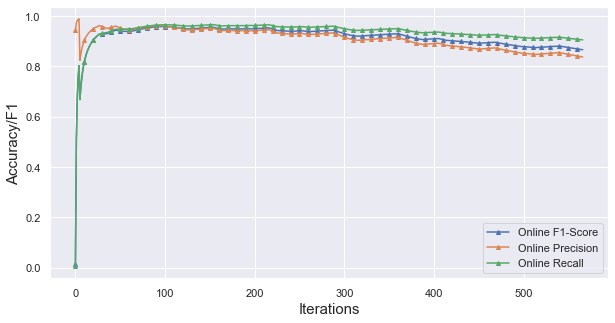

In [193]:
plt.figure(figsize=(10,5))
#plt.plot(values_dmfw[:,0][:-1],average_loss(values_dmfw[:,3][:-1]), label='Online Accuracy', marker='^', markersize=4,
#         markevery=[i for i in range(len(values_dmfw[:,0][1:])) if i%10==0])
plt.plot(obj_val_ofw[:,0][:-1],average_loss(obj_val_ofw[:,4][:-1]), label='Online F1-Score', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.plot(obj_val_ofw[:,0][:-1],average_loss(obj_val_ofw[:,5][:-1]), label='Online Precision', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.plot(obj_val_ofw[:,0][:-1],average_loss(obj_val_ofw[:,6][:-1]), label='Online Recall', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.legend(loc='lower right')
#plt.yscale("log")
plt.xlabel("Iterations",fontsize=15)
plt.ylabel("Accuracy/F1",fontsize=15)

Text(0, 0.5, 'Loss')

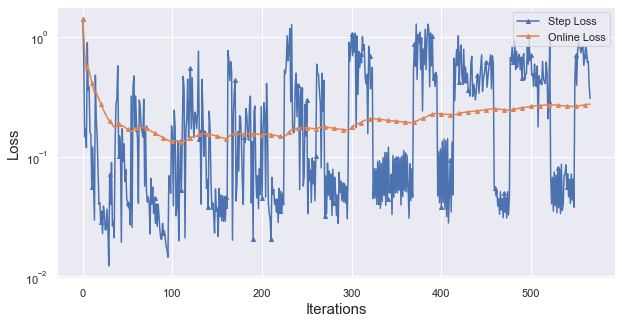

In [194]:
plt.figure(figsize=(10,5))
plt.plot(obj_val_ofw[:,0][:-1],obj_val_ofw[:,1][:-1], label='Step Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.plot(obj_val_ofw[:,0][:-1],average_loss(obj_val_ofw[:,1][:-1]), label='Online Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
plt.yscale("log")
plt.xlabel("Iterations",fontsize=15)
plt.ylabel("Loss",fontsize=15)

In [195]:
def ModelPrediction(model_to_test, date ,loader):
    correct = 0
    total = 0
    f1 = 0
    true_array = []
    pred_array = []
    model_to_test.eval()
    with torch.no_grad():
        for series, label in loader[date]:
            outputs = model_to_test(series)
            _, predicted = torch.max(outputs,1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            true_array.append(label.detach().numpy())
            pred_array.append(predicted.detach().numpy())
        truth_roll = np.hstack(true_array).flatten()
        pred_roll = np.hstack(pred_array)
        f1 = f1_score(truth_roll, pred_roll, average='weighted')
        precision = precision_score(truth_roll, pred_roll, average='weighted')
        recall = recall_score(truth_roll, pred_roll, average='weighted')
        conf_mat = confusion_matrix(truth_roll, pred_roll)
        accuracy = correct/total
        #print(classification_report(truth_roll, pred_roll))
    return accuracy, f1 , precision, recall, conf_mat, truth_roll, pred_roll
def get_real_dataset(dates, model_idx):
    real_index = [1,2,4,5]
    databydatereal = createDataByDate(resample_data_classes, "ACPower", dates)
    acpower = []
    for date in dates:
        trainy = rolling_window(databydatereal[date][f'Floor7Z{real_index[model_idx]}'], seq_len)
        #print(trainy.shape)
        acpower.append(trainy)
    acpower = np.asarray(acpower)
    #print(acpower.shape)
    shape = acpower.shape
    flatten = acpower.reshape(shape[0]*shape[1],seq_len)[::seq_len].flatten()
    return flatten[:-6]

In [196]:
test_acc = []
test_f1 = []
test_prec = []
test_rec = []
prediction = []
truth = []
model_idx = zone_no
real_index_zone = [1,2,4,5]
date_to_test = test_date[:50]
for i,date in enumerate(date_to_test):
    #print(f'-----{test_date[i]}-----')
    date_acc, date_f1, date_prec, date_rec, conf_mat, true, pred = ModelPrediction(trainer.model_ofw, test_date[i], testloader[model_idx])
    conf_mat = pd.DataFrame(conf_mat)
    test_acc.append(date_acc)
    test_f1.append(date_f1)
    test_prec.append(date_prec)
    test_rec.append(date_rec)
    #print(len(true))
    truth.append(true)
    prediction.append(pred)

In [197]:
scorepd = pd.DataFrame({"Test Acc": test_acc, 
                        "Test F1": test_f1, 
                        "Test Precision":test_prec, 
                        "Test Recall":test_rec})

real_val = resample_data[f'Floor7Z{real_index_zone[model_idx]}'].loc[resample_data[f'Floor7Z{real_index_zone[model_idx]}'].apply(lambda x: x.date in date_to_test, axis=1)]
resultpd = pd.DataFrame({"Prediction": np.asarray(prediction).flatten(),
                         "Truth": np.asarray(truth).flatten(),
                        "RealValue":get_real_dataset(date_to_test,model_idx)})



In [198]:
pd.DataFrame.to_csv(scorepd,path_log+f'/score-zone{real_index_zone[model_idx]}.csv')
pd.DataFrame.to_csv(resultpd,path_log+f'/prediction-zone{real_index_zone[model_idx]}.csv')

In [199]:
pd.DataFrame.to_csv(pd.DataFrame(set_point), path_log+f'/setpointpower.csv')

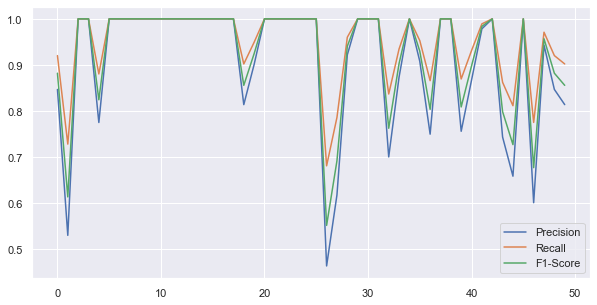

In [200]:
plt.figure(figsize=(10,5))
plt.plot(test_prec, label='Precision')
plt.plot(test_rec, label='Recall')
plt.plot(test_f1, label='F1-Score')
plt.legend()